In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.utils.data as Data
from model.TimeMAE import TimeMAE
# from TimeMAE.args import args, Test_data
from dataset import Dataset
from sklearn.manifold import TSNE
import numpy as np
from datautils import load_UCR, load_txt
import json
import argparse
import pandas as pd
# from classification import get_rep_with_label

In [2]:
np.load('exp/mono_full_EFSCV2/test/preds/label_epoch_000.npy')


array([[   0.      ,  343.75    ],
       [  31.25    ,    0.      ],
       [1125.      ,    0.      ],
       ...,
       [   7.8125  ,    0.      ],
       [   1.953125,    0.      ],
       [   0.      ,  171.875   ]])

In [2]:
test_path = 'data/no_diff_mini_EFSCV/no_diff_mini_EFSCV_TEST.txt' 
def load_file(path):
        data = pd.read_csv(path, sep='\t')
        raw_inputs = data.iloc[:, :-3].values.astype(np.float32)  # time series
        raw_labels = data.iloc[:, -2:].values.astype(np.float32)  # dopamine + serotonin
        raw_electrodes = data.iloc[:, -3] # dopamine + serotonin
        reshaped_inputs = [x.reshape(-1, 1) for x in raw_inputs]  # each: [T, 1]
        return reshaped_inputs, raw_labels, raw_electrodes

# TRAIN_DATA_ALL, TRAIN_LABELS_ALL, TRAIN_ELECTRODES_ALL = load_file(train_all_path)
# TRAIN_DATA, TRAIN_LABELS, TRAIN_ELECTRODES = load_file(train_path)
TEST_DATA, TEST_LABELS, TEST_ELECTRODES = load_file(test_path)

In [3]:
def padding_varying_length(data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i, j, :][np.isnan(data[i, j, :])] = 0
    return data
TEST_DATA = padding_varying_length(np.array(TEST_DATA))
Test_data= [np.array(TEST_DATA), np.array(TEST_LABELS), np.array(TEST_ELECTRODES)]

In [30]:
np.array(TEST_DATA).shape

(40800, 2499, 1)

In [33]:
np.shape(seqs)

torch.Size([128, 2504, 1])

In [3]:
with open('exp/mono_full_EFSCV2/test/args.json', 'r') as file:
    args = json.load(file)

args = argparse.Namespace(**args)

Train_data_all, Train_data, Test_data, label_dict = load_txt(folder=args.UCR_folder)
args.num_class = len(set(Train_data[1]))
train_linear_dataset = Dataset(device=args.device, mode='supervise_train', data=Train_data, wave_len=args.wave_length)
train_linear_loader = Data.DataLoader(train_linear_dataset, batch_size=args.train_batch_size, shuffle=True)
test_dataset = Dataset(device=args.device, mode='test', data=Test_data, wave_len=args.wave_length)
test_loader = Data.DataLoader(test_dataset, batch_size=args.test_batch_size)
args.data_shape = test_dataset.shape()
args.num_targets = 2
model = TimeMAE(args)
state_dict = torch.load('exp/EFSCV_full/test/model.pkl', map_location='cpu')
model_state_dict = model.state_dict()
for name, param in state_dict.items():
    if name in model_state_dict:
        if param.shape == model_state_dict[name].shape:
            model_state_dict[name] = param
        else:
            print(f"Skipping {name} due to shape mismatch: {param.shape} vs {model_state_dict[name].shape}")
model.load_state_dict(model_state_dict)
model.linear_proba = True
model.eval()

# reps = []
# labels = []
# with torch.no_grad():
#     for idx, batch in enumerate(tqdm(test_loader)):
#         seqs, label = batch
#         label = label.numpy()
#         rep_batch = model(seqs)
#         for i in range(len(rep_batch)):
#             reps.append(rep_batch[i].numpy())
#             labels.append(label[i])
# reps= np.array(reps)
# tsne = TSNE(n_components=2, random_state=4399)
# rep_new = tsne.fit_transform(reps)


loading_data


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Text(0.5, 1.0, 'Loss Curve')

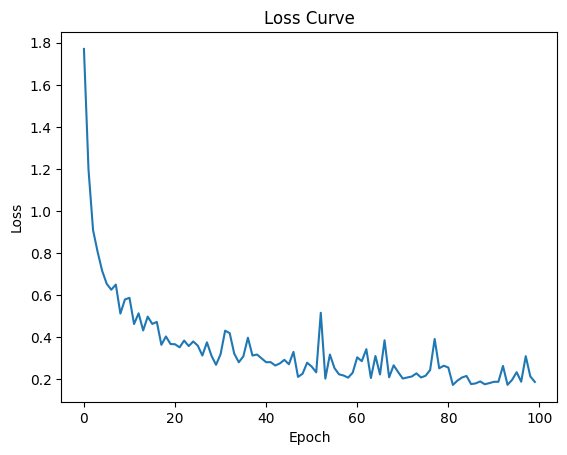

In [32]:
loss = np.loadtxt('exp/smallFSCV/test/loss.txt')
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

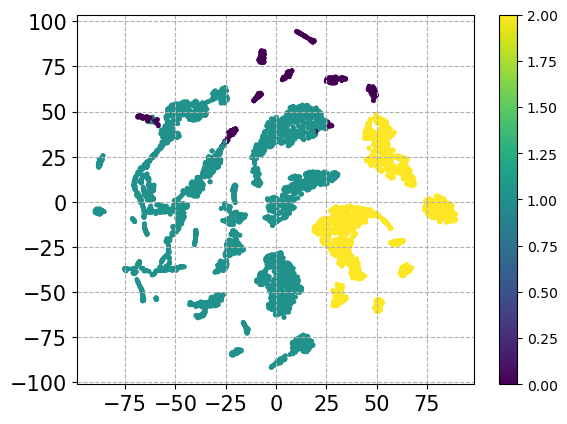

In [5]:
plt.scatter(rep_new[:, 0], rep_new[:, 1], c=labels, s=6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
# plt.savefig('exp/smallFSCV/random.svg', format='svg')
plt.colorbar()
plt.show()

#check if overlap is low concentration

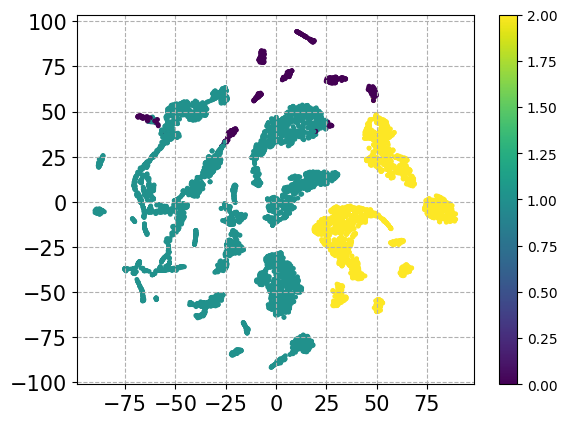

In [9]:
plt.scatter(rep_new[:, 0], rep_new[:, 1], c=labels, s=6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
# plt.savefig('exp/smallFSCV/random.svg', format='svg')
plt.colorbar()
plt.show()



In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def get_rep_with_label(model, dataloader):
    reps = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            seq, label = batch
            seq = seq.to(args.device)
            labels += label.cpu().numpy().tolist()
            rep = model(seq)
            reps += rep.cpu().numpy().tolist()
    return reps, labels


def fit_lr(features, y):
    pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            random_state=3407,
            max_iter=1000000,
            multi_class='ovr'
        )
    )
    pipe.fit(features, y)
    return pipe
train_rep, train_label = get_rep_with_label(model, train_linear_loader)
test_rep, test_label = get_rep_with_label(model, test_loader)

100%|██████████| 63/63 [00:01<00:00, 41.57it/s]


In [34]:
clf = fit_lr(train_rep, train_label)
acc = clf.score(test_rep, test_label)

In [37]:
clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000000, multi_class='ovr',
                                    random_state=3407))])

In [12]:
def padding_varying_length(data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i, j, :][np.isnan(data[i, j, :])] = 0
    return data


Path='data/'
folder='DVSFSCV'
train_path = Path + folder + '/' + folder + '_TRAIN.txt'
test_path = Path + folder + '/' + folder + '_TEST.txt'
TRAIN_DATA = []
TRAIN_LABEL = []
label_dict = {}
label_index = 0

data = pd.read_csv(train_path, sep='\t')

for index in range(data.shape[0]):
    raw_data = np.array(list(data.iloc[index,:-1]))
    raw_label = data.iloc[index,-1]
    if label_dict.__contains__(raw_label):
        TRAIN_LABEL.append(label_dict[raw_label])
    else:
        label_dict[raw_label] = label_index
        TRAIN_LABEL.append(label_index)
        label_index += 1
    TRAIN_DATA.append(np.array(raw_data).astype(np.float32).reshape(-1, 1))

TRAIN_DATA = padding_varying_length(np.array(TRAIN_DATA))

data = pd.read_csv(test_path, sep='\t')
TEST_DATA = []
TEST_LABEL = []
for index in range(data.shape[0]):
    raw_data = np.array(list(data.iloc[index,:-1]))
    raw_label = data.iloc[index,-1]
    if label_dict.__contains__(raw_label):
        TEST_LABEL.append(label_dict[raw_label])
    else:
        label_dict[raw_label] = label_index
        TEST_LABEL.append(label_index)
        label_index += 1
    TEST_DATA.append(np.array(raw_data).astype(np.float32).reshape(-1, 1))
TEST_DATA = padding_varying_length(np.array(TEST_DATA))


# return [np.array(TRAIN_DATA), np.array(TRAIN_LABEL)], [np.array(TRAIN_DATA), np.array(TRAIN_LABEL)], [
#     np.array(TEST_DATA), np.array(TEST_LABEL)]    


In [5]:
[rep_mask, rep_mask_prediction], [token_prediction_prob, tokens], visible, mask = model.pretrain_forward(batch[0])

In [6]:
visible.shape

torch.Size([64, 9, 64])

In [7]:
mask.shape

torch.Size([64, 12, 64])

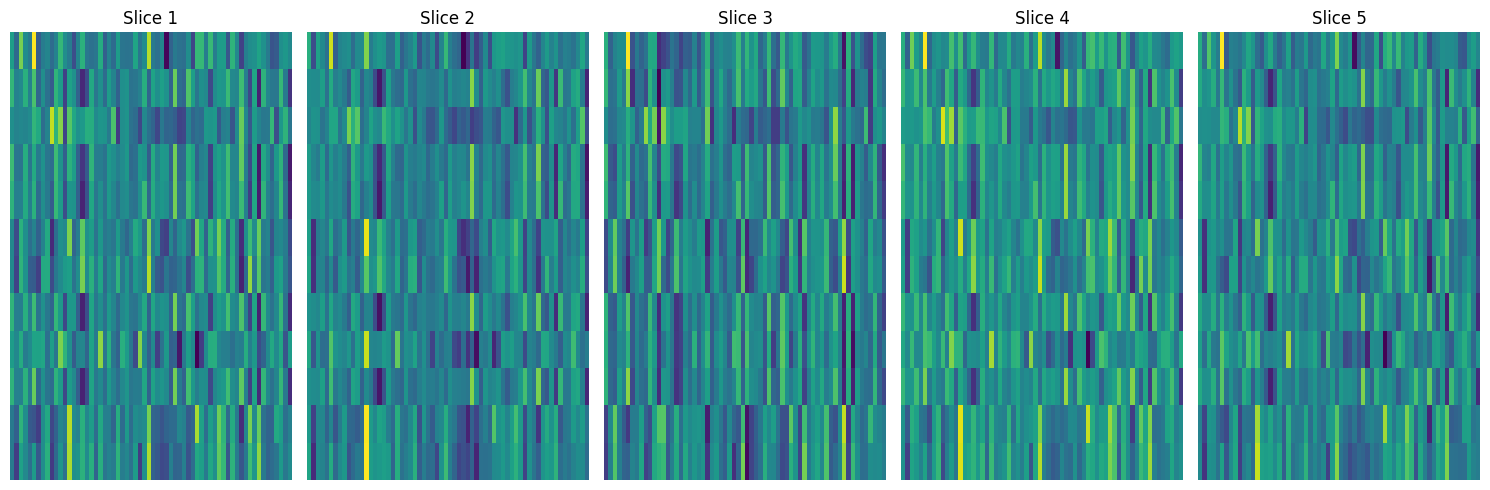

In [5]:
# Plotting the first 5 slices for demonstration (you can adjust this)
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Show the first 5 slices as images
for i in range(5):
    axs[i].imshow(rep_mask[i], cmap='viridis', aspect='auto')
    axs[i].set_title(f"Slice {i+1}")
    axs[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

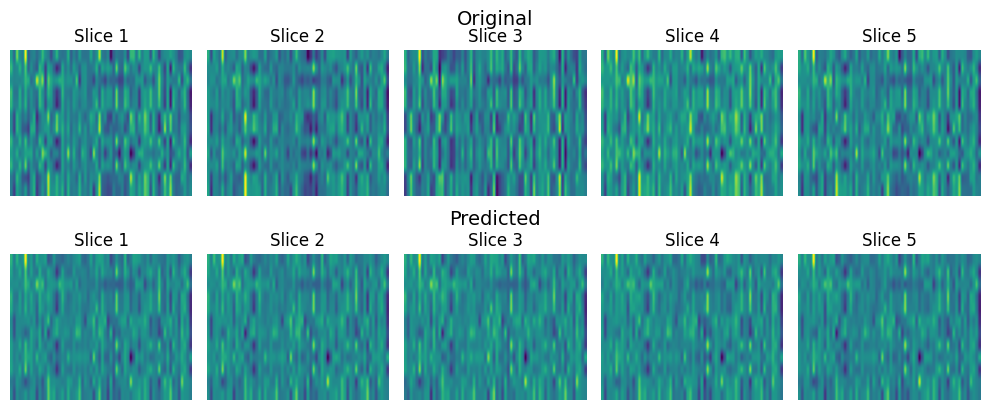

In [6]:
rmp=rep_mask_prediction.detach().numpy() 
# Plotting the first 5 slices for demonstration (you can adjust this)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

# Show the first 5 slices as images
for i in range(5):
    axs[0,i].imshow(rep_mask[i], cmap='viridis', aspect='auto')
    axs[0,i].set_title(f"Slice {i+1}")
    axs[0,i].axis('off')  # Hide axes
    axs[1,i].imshow(rmp[i], cmap='viridis', aspect='auto')
    axs[1,i].set_title(f"Slice {i+1}")
    axs[1,i].axis('off')  # Hide axes
fig.text(0.5, 1, 'Original', ha='center', fontsize=14)
fig.text(0.5, 0.6, 'Predicted', ha='center', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.25, hspace=0.4)  # Adjust hspace to add space between rows

plt.show()